#Python Data Science Final Project

Jonathan Kristianto 23229555

Nathanael Iskandar Wibowo 23229579

Clarita Nathania Worrow 23229533



**Introduction**
Sentiment analysis for movie reviews using model from huggingface.

Data : rotten_tomatoes

Model : tashrifmahmud/sentiment_analysis_model_v2

In [ ]:
!pip install pandas scikit-learn transformers datasets matplotlib seaborn

Setup, Data loading, and Subsetting

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
# Model Name
model_name = "tashrifmahmud/sentiment_analysis_model_v2"

# Load and Combine Dataset
dataset = load_dataset("rotten_tomatoes")
df_full = pd.concat([dataset['train'].to_pandas(), dataset['validation'].to_pandas(), dataset['test'].to_pandas()], ignore_index=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# Create 50% Subset
df, _ = train_test_split(df_full, test_size=0.5, random_state=42, stratify=df_full['label'])
df = df.reset_index(drop=True)

df_full.shape #Shape of the whole data
df.shape #Shape of 50% from the data

(5331, 2)

EDA


 Basic Information (50%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              5331 non-null   object 
 1   label             5331 non-null   int64  
 2   text_length       5331 non-null   int64  
 3   pred_label_base   5331 non-null   int64  
 4   pred_score_base   5331 non-null   float64
 5   text_clean        5331 non-null   object 
 6   pred_label_clean  5331 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 291.7+ KB
None
0
text                0
label               0
text_length         0
pred_label_base     0
pred_score_base     0
text_clean          0
pred_label_clean    0
dtype: int64


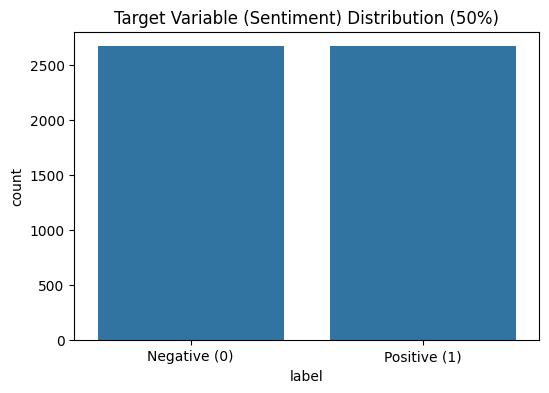

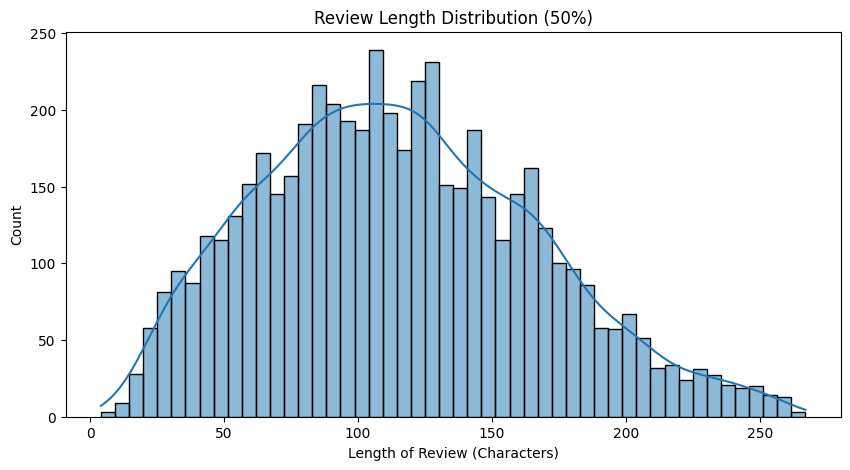


Average Text Length: 115.07


In [ ]:
print("\n Basic Information (50%)")
print(df.info())

# Check duplicates and missing values
print(df.duplicated().sum()) # Duplicate check
print(df.isnull().sum()) #Missing Values/column

# Review Data Distribution (Target)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Target Variable (Sentiment) Distribution (50%)')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()


# Review Length Distribution
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Review Length Distribution (50%)')
plt.xlabel('Length of Review (Characters)')
plt.show()

print(f"\nAverage Text Length: {df['text_length'].mean():.2f}")

Baseline Model Application and Evaluation

In [ ]:
def get_numerical_label(prediction):
    label_str = prediction['label']
    if label_str == 'POSITIVE':
        return 1
    elif label_str == 'NEGATIVE':
        return 0
    elif label_str.startswith('LABEL_'):
        return int(label_str.split('_')[-1])
    else:
        raise ValueError(f"Unknown label output by model: {label_str}")

In [ ]:
# Load Pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    device=0 if torch.cuda.is_available() else -1
)

Device set to use cpu


In [ ]:
# Predict for all samples (Subset)
predictions = sentiment_pipeline(df['text'].tolist())

df['pred_label_base'] = [get_numerical_label(p) for p in predictions]
df['pred_score_base'] = [p['score'] for p in predictions]



 Overall Baseline Model Accuracy
Accuracy (50%): 0.8844


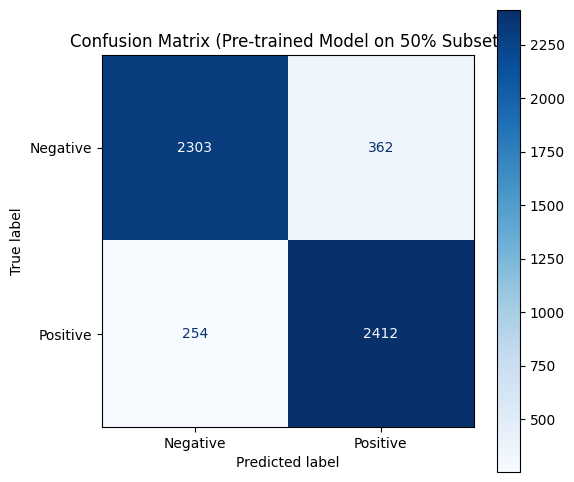

In [ ]:
# Evaluation and Visualization
true_labels = df['label'].tolist()
predicted_labels_base = df['pred_label_base'].tolist()

overall_accuracy = accuracy_score(true_labels, predicted_labels_base)
print(f"\n Overall Baseline Model Accuracy")
print(f"Accuracy (50%): {overall_accuracy:.4f}")

cm_base = confusion_matrix(true_labels, predicted_labels_base)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp_base.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix (Pre-trained Model on 50% Subset)')
plt.show()

Fine-tuning preparation and text cleaning

In [ ]:
# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Apply cleaning to the subset
df['text_clean'] = df['text'].apply(clean_text)

# Re-evaluation with Cleaned Text
predictions_clean = sentiment_pipeline(df['text_clean'].tolist())
df['pred_label_clean'] = [get_numerical_label(p) for p in predictions_clean]
accuracy_clean = accuracy_score(df['label'].tolist(), df['pred_label_clean'].tolist())
print(f"\nAccuracy on CLEANED text (Baseline Model): {accuracy_clean:.4f}")


Accuracy on CLEANED text (Baseline Model): 0.8745


Final Fine-tuning run

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

In [ ]:
# Data Splitting and Tokenization (Using Cleaned Text)

# 1. CREATE THE TINY SUBSET (~530 SAMPLES)
df_tiny_subset, _ = train_test_split(df, test_size=0.9, random_state=42, stratify=df['label'])

print(f"Total Tiny Subset Size for Fine-Tuning: {df_tiny_subset.shape[0]}")



Total Tiny Subset Size for Fine-Tuning: 533


In [ ]:
# 2. SPLIT TINY SUBSET INTO TRAIN/VAL/TEST
df_ft_train_val, df_ft_test = train_test_split(df_tiny_subset, test_size=0.20, random_state=42, stratify=df_tiny_subset['label'])
df_ft_train, df_ft_val = train_test_split(df_ft_train_val, test_size=0.20, random_state=42, stratify=df_ft_train_val['label'])

print(f"Training Samples: {df_ft_train.shape[0]}, Validation Samples: {df_ft_val.shape[0]}, Test Samples: {df_ft_test.shape[0]}")

Training Samples: 340, Validation Samples: 86, Test Samples: 107


In [ ]:
# Apply cleaning to the splits
df_ft_train['text_clean'] = df_ft_train['text'].apply(clean_text)
df_ft_val['text_clean'] = df_ft_val['text'].apply(clean_text)
df_ft_test['text_clean'] = df_ft_test['text'].apply(clean_text)

In [ ]:
# Convert to HF Dataset objects
train_dataset = Dataset.from_pandas(df_ft_train)
val_dataset = Dataset.from_pandas(df_ft_val)
test_dataset = Dataset.from_pandas(df_ft_test)

tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(examples):
    return tokenizer(examples["text_clean"], truncation=True)

In [ ]:
# Tokenize
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True).rename_column("label", "labels").remove_columns(['text', 'text_length', 'text_clean', '__index_level_0__'])
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True).rename_column("label", "labels").remove_columns(['text', 'text_length', 'text_clean', '__index_level_0__'])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True).rename_column("label", "labels").remove_columns(['text', 'text_length', 'text_clean', '__index_level_0__'])



Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

In [ ]:
# Load Model and Define Metrics
model_ft = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}


In [ ]:
# Define Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./ft_results_tiny_data",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",

    logging_steps=50,
    load_best_model_at_end=True,
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



In [ ]:
# Initialize and Run the Trainer
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.287106,0.860465
2,No log,0.439492,0.848837
3,0.226900,0.378379,0.883721


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=66, training_loss=0.19336195425553757, metrics={'train_runtime': 301.7491, 'train_samples_per_second': 3.38, 'train_steps_per_second': 0.219, 'total_flos': 11728539288816.0, 'train_loss': 0.19336195425553757, 'epoch': 3.0})

In [ ]:
# Evaluate and Visualize Final Results
test_results = trainer.predict(tokenized_test_dataset)
ft_predictions = np.argmax(test_results.predictions, axis=-1)
ft_true_labels = test_results.label_ids

ft_accuracy = accuracy_score(ft_true_labels, ft_predictions)
print(f"Accuracy: {ft_accuracy:.4f}")

ft_cm = confusion_matrix(ft_true_labels, ft_predictions)
disp_ft = ConfusionMatrixDisplay(confusion_matrix=ft_cm, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp_ft.plot(ax=ax)
plt.title('Final Confusion Matrix')
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



 Final Fine-Tuned Model Accuracy
Accuracy: 0.85981

 Final Confusion Matrix
[[41 12]
 [ 3 51]]


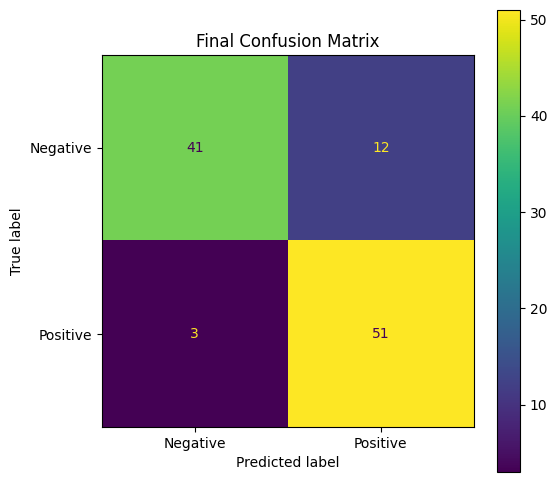

In [ ]:
# 1. Get Predictions on the Fine-Tuned Test Set
test_results = trainer.predict(tokenized_test_dataset)
ft_predictions = np.argmax(test_results.predictions, axis=-1)
ft_true_labels = test_results.label_ids

# 2. Compute Accuracy and Confusion Matrix
ft_accuracy = accuracy_score(ft_true_labels, ft_predictions)
print(f"\n Final Fine-Tuned Model Accuracy")
print(f"Accuracy: {ft_accuracy:.5f}")

ft_cm = confusion_matrix(ft_true_labels, ft_predictions)
print("\n Final Confusion Matrix")
print(ft_cm)

# 3. Visualize Confusion Matrix
disp_ft = ConfusionMatrixDisplay(confusion_matrix=ft_cm, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp_ft.plot(ax=ax)
plt.title('Final Confusion Matrix')
plt.show()

**Conclusion**

We are performing sentiment analysis. Initially, a baseline model achieved an accuracy of 0.8844 on the 50% subset of the dataset. After applying text cleaning, the baseline model's accuracy slightly dropped to 0.8745. Finally, a fine-tuned model trained on a tiny subset of approximately 530 samples reached an accuracy of 0.8598.

